Total Acceleration=Gravity+User Acceleration

The dataset contains various columns, but we'll focus on Acceleration_x, Acceleration_y, and Acceleration_z for this analysis.

Next, let's proceed with the calculations:

Velocity: We'll integrate the acceleration data to obtain velocity. For the integration, we'll need to know the time interval between each data point. Could you please provide this information?

Position: After getting the velocity, we'll integrate again to obtain the position.

Energy: Kinetic energy is given by 
�
�
=
1
2
�
�
2
KE= 
2
1
​
 mv 
2
 , where 
�
m is mass and 
�
v is the velocity. If we assume a constant mass, we can compute the kinetic energy for each data point based on the calculated velocity.

Dominant Frequencies: We'll perform a Fast Fourier Transform (FFT) on the acceleration data to find the dominant frequencies.

Could you please provide the time interval between each data sample?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:

data = pd.read_csv('./Motion/jog_9/sub_1.csv')

    # Calculate the time array
num_samples = len(data)
len(data)

4861

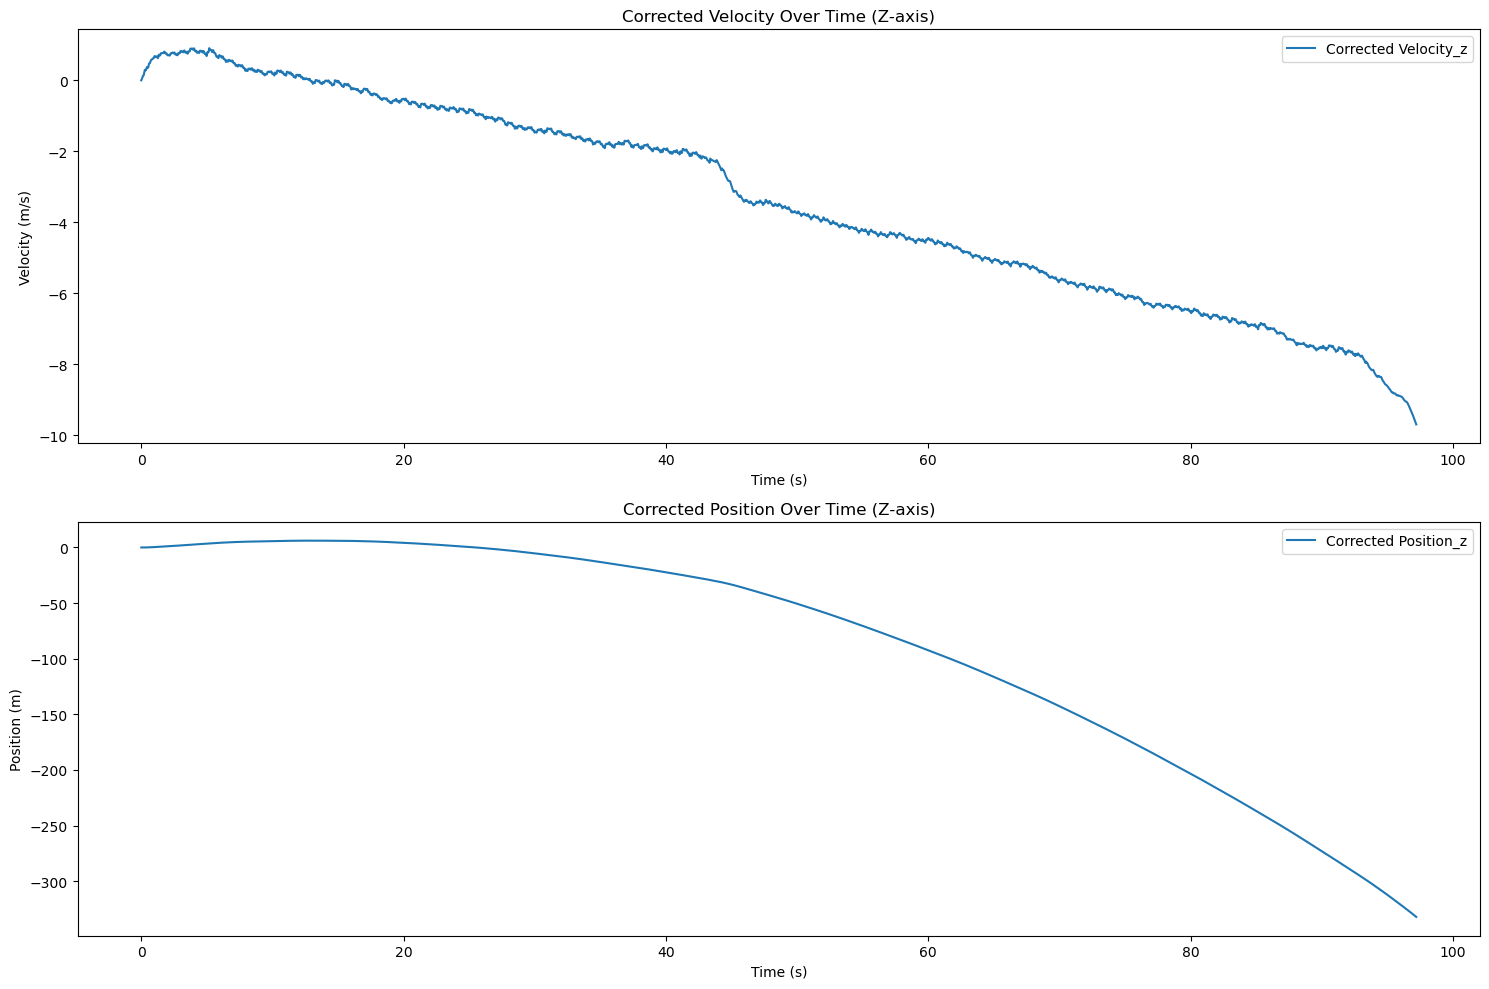

In [3]:
def analyze_motion_data(file_path):
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Calculate the time array
    num_samples = len(data)
    dt = 1 / 50.0  # Sample rate is 50Hz
    time_array = np.linspace(0, (num_samples - 1) * dt, num_samples)
    
    # Calculate total user acceleration
    data['userAcceleration.z'] = np.sqrt(data['userAcceleration.x']**2 + data['userAcceleration.y']**2 + data['userAcceleration.z']**2)
    
    # Initialize arrays for corrected acceleration, velocity, and position
    corrected_acceleration_z = np.zeros_like(data['userAcceleration.z'])
    corrected_velocity_z = np.zeros_like(data['userAcceleration.z'])
    corrected_position_z = np.zeros_like(data['userAcceleration.z'])
    
    # Initialize variables for the complementary filter
    prev_angle = 0.0

    # Time constant for the complementary filter
    tau = 0.98

    # Apply the complementary filter and integrate to get corrected velocity and position
    for i in range(len(data)):
        # Get the current accelerometer and gyroscope readings
        accel_z = data['userAcceleration.z'][i]
        gyro_z = data['rotationRate.z'][i]

        # Apply the complementary filter to estimate the angle
        angle = tau * (prev_angle + gyro_z * dt) + (1 - tau) * accel_z
        prev_angle = angle

        # Correct the acceleration reading based on the estimated angle
        corrected_acceleration_z[i] = accel_z - angle

    for i in range(1, len(corrected_acceleration_z)):
        corrected_velocity_z[i] = corrected_velocity_z[i - 1] + (corrected_acceleration_z[i] + corrected_acceleration_z[i - 1]) * dt / 2
        corrected_position_z[i] = corrected_position_z[i - 1] + (corrected_velocity_z[i] + corrected_velocity_z[i - 1]) * dt / 2
    
    # Plotting corrected velocity and position over time for Z-axis
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plotting Velocity
    axs[0].plot(time_array, corrected_velocity_z, label='Corrected Velocity_z')
    axs[0].set_title('Corrected Velocity Over Time (Z-axis)')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity (m/s)')
    axs[0].legend()
    
    # Plotting Position
    axs[1].plot(time_array, corrected_position_z, label='Corrected Position_z')
    axs[1].set_title('Corrected Position Over Time (Z-axis)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Position (m)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# Test the function with one of the provided files
analyze_motion_data('./Motion/jog_9/sub_1.csv')


## Due to drift, use high pass filter

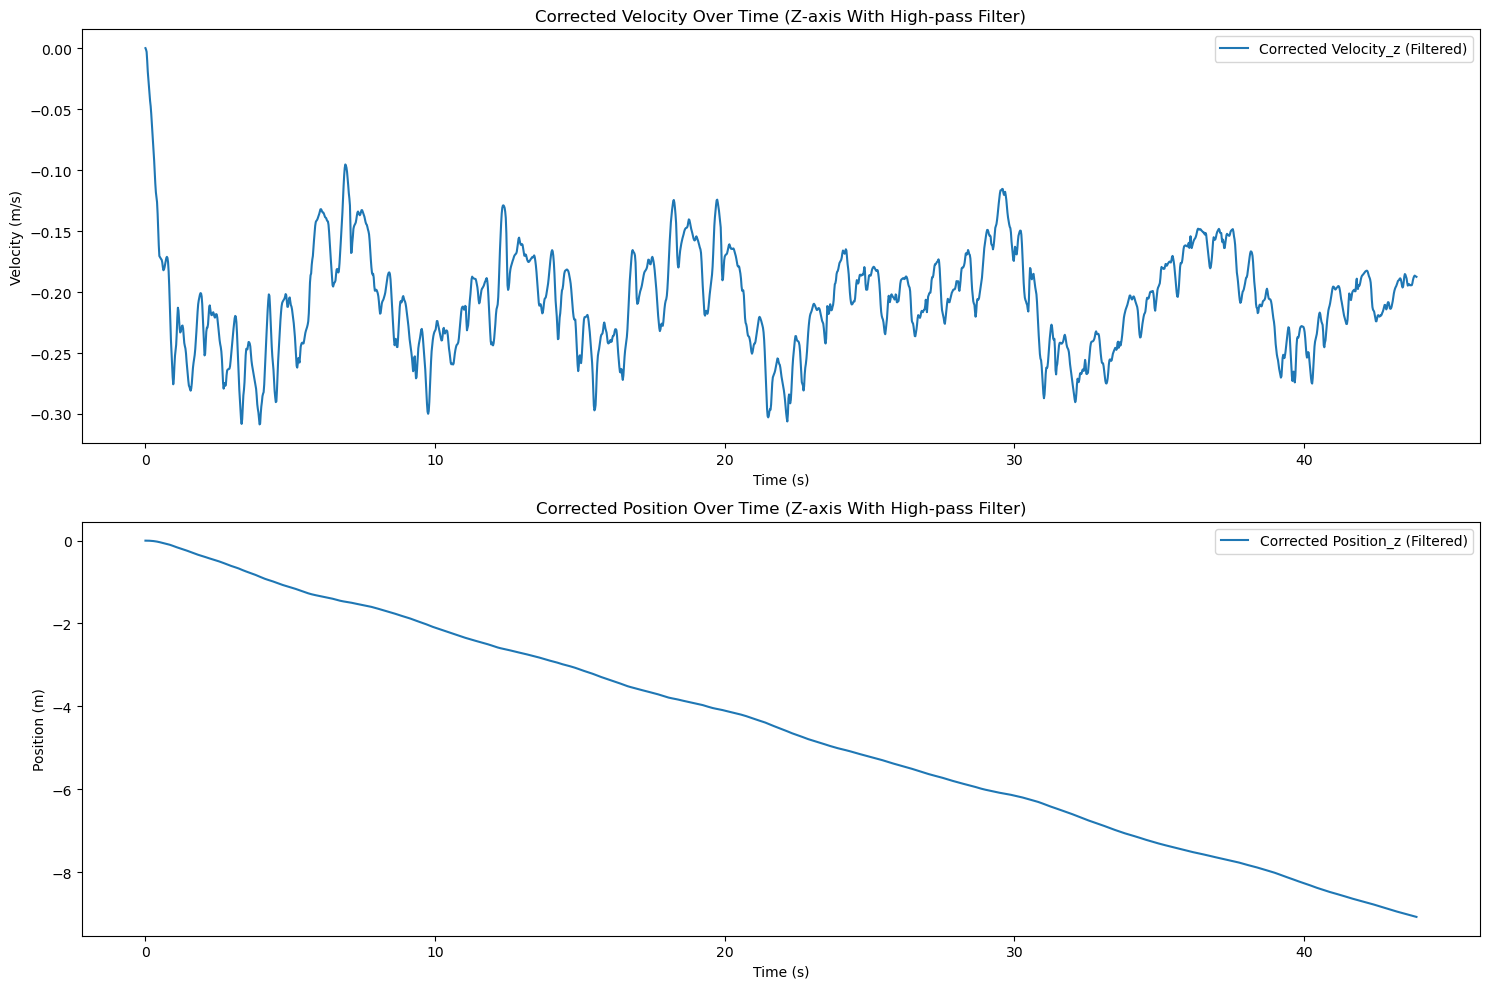

In [56]:
from scipy.signal import butter, filtfilt

def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)

def analyze_motion_data_with_filter(file_path):
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Calculate the time array
    num_samples = len(data)
    dt = 1 / 50.0  # Sample rate is 50Hz
    time_array = np.linspace(0, (num_samples - 1) * dt, num_samples)
    
    # Initialize arrays for corrected acceleration, velocity, and position
    corrected_acceleration_z = np.zeros_like(data['userAcceleration.z'])
    corrected_velocity_z = np.zeros_like(data['userAcceleration.z'])
    corrected_position_z = np.zeros_like(data['userAcceleration.z'])
    
    # Apply high-pass filter to userAcceleration.z
    cutoff_frequency = 0.1  # Cutoff frequency in Hz
    filtered_acceleration_z = apply_highpass_filter(data['userAcceleration.z'], cutoff_frequency, 1/dt)
    
    # Integrate the corrected acceleration to get velocity and position
    for i in range(1, len(filtered_acceleration_z)):
        corrected_velocity_z[i] = corrected_velocity_z[i - 1] + (filtered_acceleration_z[i] + filtered_acceleration_z[i - 1]) * dt / 2
        corrected_position_z[i] = corrected_position_z[i - 1] + (corrected_velocity_z[i] + corrected_velocity_z[i - 1]) * dt / 2
    
    # Plotting corrected velocity and position over time for Z-axis
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plotting Velocity
    axs[0].plot(time_array, corrected_velocity_z, label='Corrected Velocity_z (Filtered)')
    axs[0].set_title('Corrected Velocity Over Time (Z-axis With High-pass Filter)')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity (m/s)')
    axs[0].legend()
    
    # Plotting Position
    axs[1].plot(time_array, corrected_position_z, label='Corrected Position_z (Filtered)')
    axs[1].set_title('Corrected Position Over Time (Z-axis With High-pass Filter)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Position (m)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# Test the function with the jogging data file
analyze_motion_data_with_filter('./Motion/ups_3/sub_1.csv')

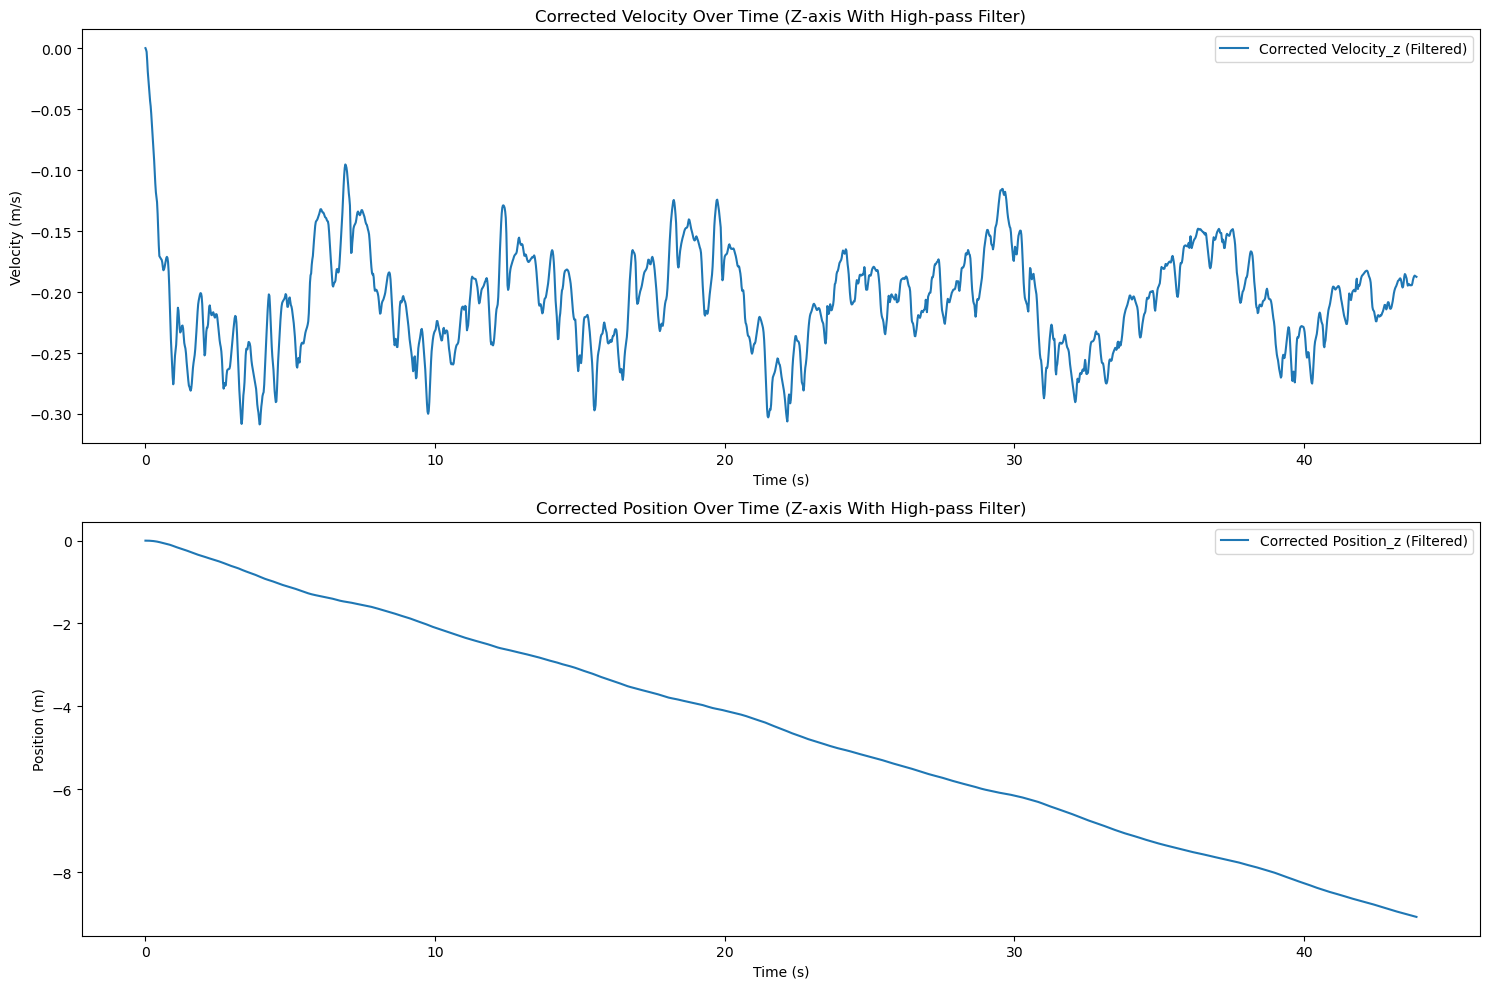

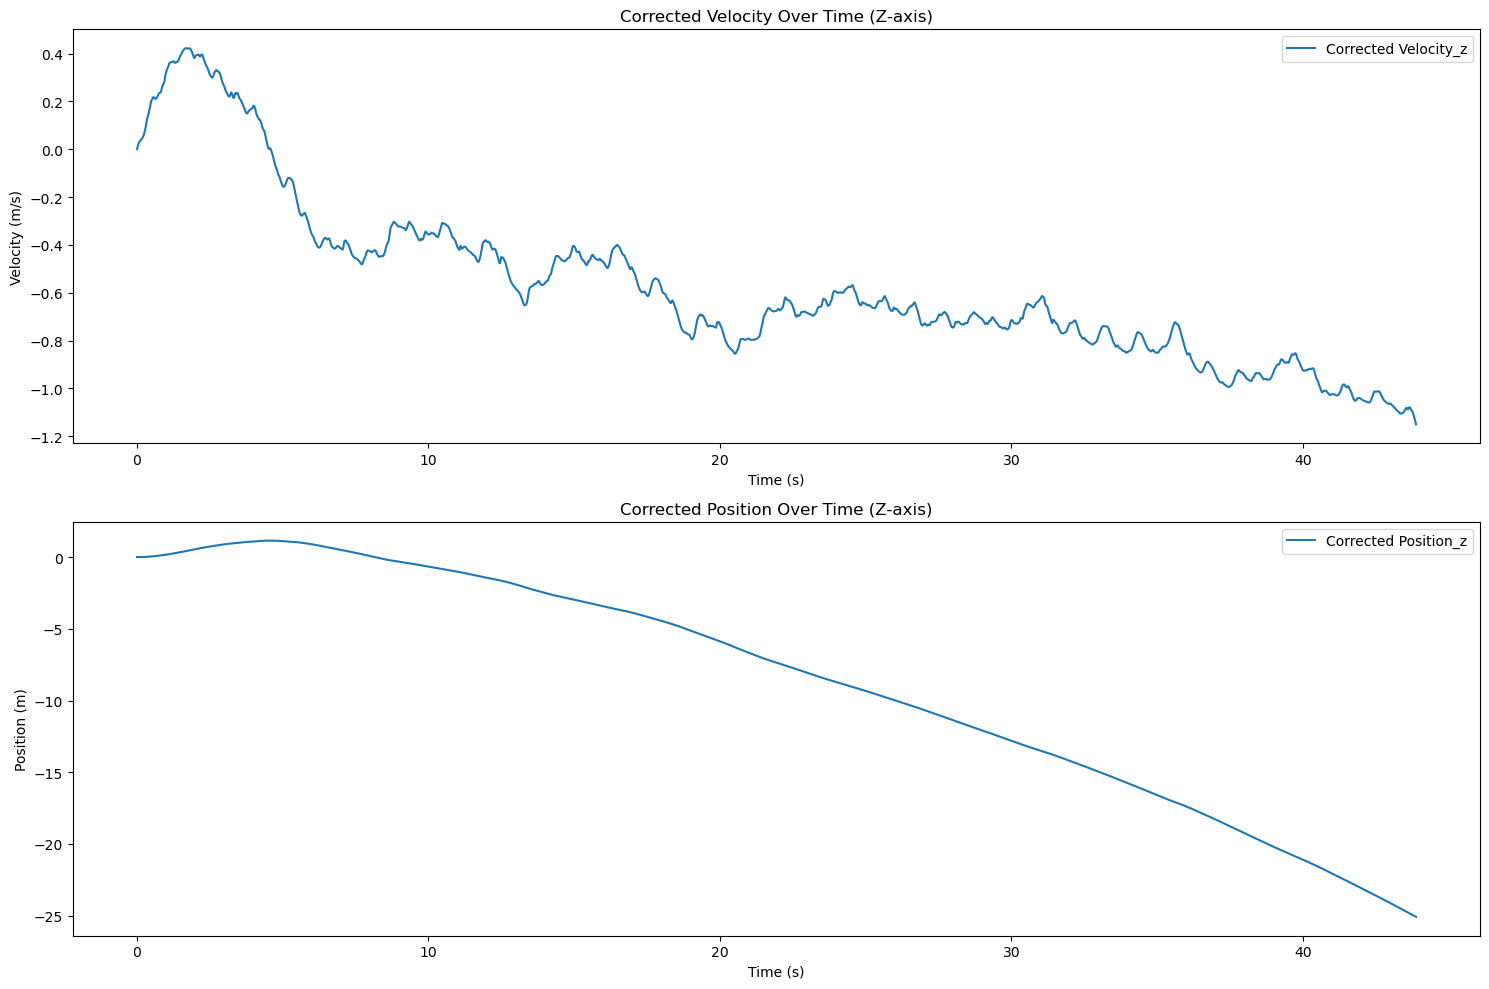

In [57]:
analyze_motion_data_with_filter('./Motion/ups_3/sub_1.csv')
analyze_motion_data('./Motion/ups_3/sub_1.csv')